![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics


In [8]:
import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import cm

#Some plot settings
%run plot_functions/plot_settings.py

In [9]:
#element class
class quad4_element():#local coordinates go from -1 to 1
    #takes global nodal coordinates, global node ids
    def __init__(self, ncoords=[[0.,0.],[1.,0.],[1.,1.],[0.,1.]], nids=[0,1,2,3]):
        self.__nnodes = 4
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = np.array([[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]])
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = 2
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
    
    def get_centroid(self):
        return [np.mean(self.__coords[:,0]),np.mean(self.__coords[:,1])]

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [10]:
#quadratic elements
dx = 10.
dy = 10.
nelx = 6
nely = 6

nnx = nelx+1
nny = nely+1
node_list = np.array([[0.0,0.0]]*(nnx)*(nny))
c = 0
for i in range(nnx):
    for j in range(nny):
        node_list[c][0] = (i/nelx)*dx
        node_list[c][1] = (j/nely)*dy
        c += 1
        
        
connectivity = [[]]
for i in range(nelx):
    for j in range(nely):
        connectivity.append([j+i*nny,j+(i+1)*nny,j+(i+1)*nny+1,j+i*nny+1]) #j+i*nx,j+i*nx+3,j+i*nx+4,j+i*nx+1

connectivity.remove([])

element_vector = []
for i in range(len(connectivity)):
    element_vector.append(quad4_element([node_list[connectivity[i][0]],
                                         node_list[connectivity[i][1]],
                                         node_list[connectivity[i][2]],
                                         node_list[connectivity[i][3]]],
                                        connectivity[i]))
solution = np.array([0.]*len(node_list))

Let's plot the mesh.

In [11]:
def plot_mesh(node_list,element_vector):
    fig, ax = plt.subplots()
    for i in range(len(node_list)):
        ax.plot(node_list[i][0],node_list[i][1],color='black',marker='o')
        ax.text(node_list[i][0]+dx/150,node_list[i][1]+dy/150,'%i' %i)
    for ne,e in enumerate(element_vector):
        e_coords = e._quad4_element__coords
        for i in range(len(e_coords)):
            ax.plot([e_coords[i-1,0],e_coords[i,0]],[e_coords[i-1,1],e_coords[i,1]],color='blue')
        ax.text(e.get_centroid()[0],e.get_centroid()[1],'%i' %ne, color='blue')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal')
    fig.tight_layout();

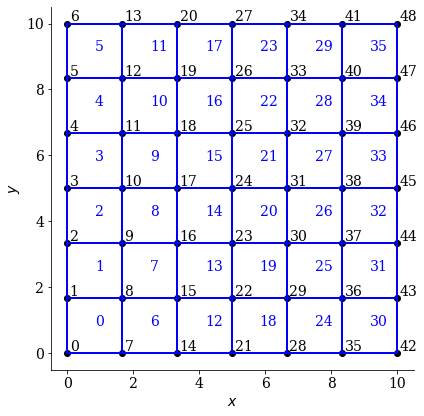

In [12]:
plot_mesh(node_list,element_vector)

## Bilinear shape functions in 2D


Linear elements have two nodes with $\xi_1 = -1$ and $\xi_2 = 1$. The linear shape functions are

\begin{align}
    N_1(\xi,\eta) &= \frac{1}{4} (1-\xi)(1-\eta) \\
    N_2(\xi,\eta) &= \frac{1}{4} (1+\xi)(1-\eta) \\
    N_3(\xi,\eta) &= \frac{1}{4} (1+\xi)(1+\eta) \\
    N_4(\xi,\eta) &= \frac{1}{4} (1-\xi)(1+\eta)
\end{align}

Their gradients in natural coordinates follow as

\begin{align}
    \frac{\text{d} N_1}{\text{d}\xi} &= - \frac{1}{4} (1-\eta) \qquad \frac{\text{d} N_1}{\text{d}\eta} = - \frac{1}{4} (1-\xi) \\
    \frac{\text{d} N_2}{\text{d}\xi} &= + \frac{1}{4} (1-\eta) \qquad \frac{\text{d} N_2}{\text{d}\eta} = - \frac{1}{4} (1+\xi) \\
    \frac{\text{d} N_3}{\text{d}\xi} &= + \frac{1}{4} (1+\eta) \qquad \frac{\text{d} N_3}{\text{d}\eta} = + \frac{1}{4} (1+\xi) \\
    \frac{\text{d} N_4}{\text{d}\xi} &= - \frac{1}{4} (1+\eta) \qquad \frac{\text{d} N_4}{\text{d}\eta} = + \frac{1}{4} (1-\xi)
\end{align}

### Jacobians and gradients

An unknown is approximated as $u \approx N_i \hat{u}_i$ where $i$ runs over all nodes of a given element and $\hat{u}_i$ are the nodal degrees of freedom. To peform a gradient calculation (here in 1D) 

$$
    \text{grad} u = \frac{\text{d} u}{\text{d} x_k} = \frac{\text{d}N_i}{\text{d} x_k} \hat{u}_i = \frac{\text{d}N_i}{\text{d} \xi_j} \frac{\text{d}\xi_j}{\text{d} x_k} \hat{u}_i = \frac{\text{d}N_i}{\text{d} \xi_j} J_{jk}^{-1} \hat{u}_i
$$

The element Jacobian follows from the isoparametric coordinate approximation $x_k \approx N_i \hat{x}_k^i$ where $\hat{x}_k^i$ are the nodal coordinates in the $k$ direction:

$$
    J_{jk} = \frac{\text{d} x_j}{\text{d}\xi_k} = \frac{\text{d} N_i}{\text{d}\xi_k} \hat{x}_j^i
$$

We use the following shorthand:

$$
    \nabla N_{ij} = \frac{\text{d}N_i}{\text{d} x_j} = \frac{\text{d}N_i}{\text{d} \xi_k} J_{kj}^{-1}
$$

In [13]:
#N
def shape_function(xi,eta):
    return np.array([(1-xi)*(1-eta),
                     (1+xi)*(1-eta),
                     (1+xi)*(1+eta),
                     (1-xi)*(1+eta)])/4.
#dN_dxi
def dshape_function_dxi(xi,eta):
    return np.array([[-(1-eta), -(1-xi)],
                     [+(1-eta), -(1+xi)],
                     [+(1+eta), +(1+xi)],
                     [-(1+eta), +(1-xi)]])/4.

    
#untested
def element_jacobian(xi,eta,element):
    Jacobian = np.dot(dshape_function_dxi(xi,eta).T,element._quad4_element__coords)
    #Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#untested
def grad_shape_function(xi,eta,element):
    Jac = element_jacobian(xi,eta,element)
    return np.dot(dshape_function_dxi(xi,eta),np.linalg.inv(Jac))

In [14]:
def test_gradN(xi,eta):
    dNdX = dshape_function_dxi(xi,eta)
    dNdX_num1 = (shape_function(xi+1e-8,eta) - shape_function(xi-1e-8,eta))/2e-8
    dNdX_num2 = (shape_function(xi,eta+1e-8) - shape_function(xi,eta-1e-8))/2e-8
    dNdX_num = np.array([dNdX_num1,dNdX_num2]).T
    return np.max(dNdX_num-dNdX)

In [15]:
xis = np.linspace(-1,1,10)
for x in xis:
    for y in xis:
        if (test_gradN(x,y) >1e-8):
            print("ERROR")

## Testing interpolation and gradient calculation

Now let's plot the shape functions to see if they were implemented correctly.

In [16]:
def plot_shape_functions():
    x = np.linspace(-1.,1.,10)
    y = np.copy(x)
    X, Y = np.meshgrid(x,y)
    #print(X,Y)
    h = shape_function(X,Y)
    fig = plt.figure(figsize=(20,5))
    corners = [[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]]
    for i in range(4):
        #ax[i] = ax[i].add_subplot(111, projection='3d')
        ax = fig.add_subplot(1, 4, 1+i, projection='3d')
        ax.plot_surface(X,Y,h[i])
        ax.set_xlabel('$\\xi$')
        ax.set_ylabel('$\\eta$')
        ax.set_zlabel('$N_{%i}$' %(i+1))
        ax.plot(corners[i][0],corners[i][1],0,marker='o',color='r')
    fig.tight_layout();

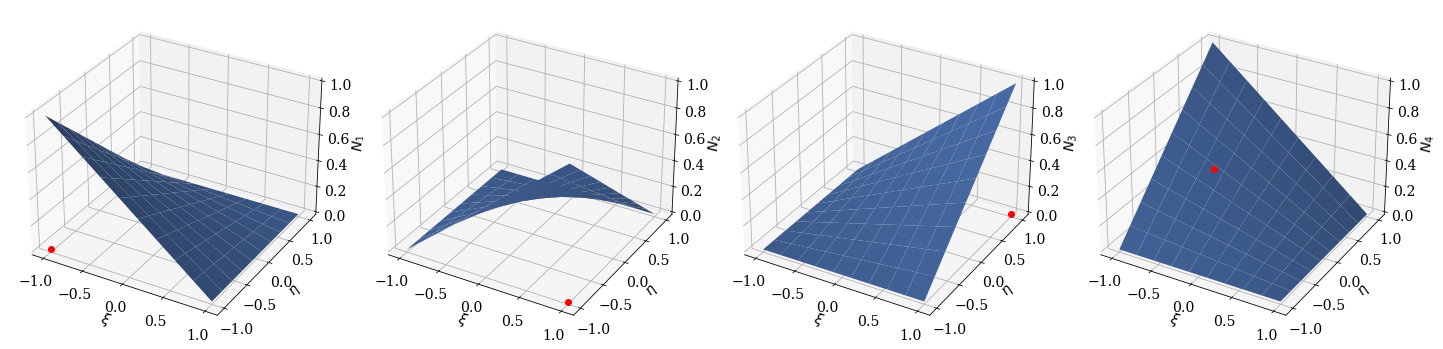

In [17]:
plot_shape_functions()

Let's assume some nodal pressures and check the gradient calculation.

In [18]:
flow_up = [10,10,0,0]
flow_right = [5,10,5,0]

In [19]:
def plot_element_field(p,elem):
    x = np.linspace(-1.,1.,10)
    y = np.copy(x)
    X, Y = np.meshgrid(x,y)
    #print(X,Y)
    fig = plt.figure(figsize=(20,5))
    corners = [[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]]
    for i in range(len(p)):
        #ax[i] = ax[i].add_subplot(111, projection='3d')
        ax = fig.add_subplot(1, 2, 1+i, projection='3d')
        ax.plot_surface(X,Y,np.dot(shape_function(X,Y).T,p[i]))
        ax.set_xlabel('$\\xi$')
        ax.set_ylabel('$\\eta$')
        ax.set_zlabel('$p$')
    fig.tight_layout();

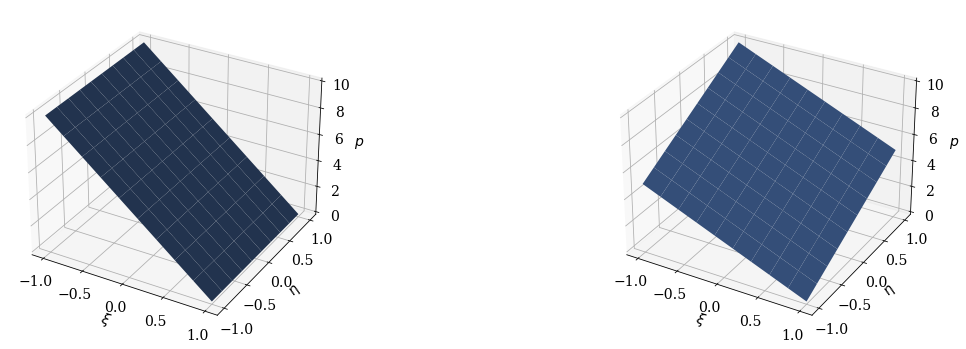

In [20]:
plot_element_field([flow_up,flow_right],element_vector[0])

In [21]:
def plot_element_gradient(p,elem):
    x = np.linspace(-1.,1.,10)
    y = np.copy(x)
    X, Y = np.meshgrid(x,y)
    #print(X,Y)
    fig = plt.figure(figsize=(20,5))
    corners = [[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]]
    for i in range(len(p)):
        #ax[i] = ax[i].add_subplot(111, projection='3d')
        ax = fig.add_subplot(1,2,1+i)
        ax.quiver(X,Y,np.dot(dshape_function_dxi(X,Y).T,p[i]).T[0],np.dot(dshape_function_dxi(X,Y).T,p[i]).T[1])
        ax.set_xlabel('$\\xi$')
        ax.set_ylabel('$\\eta$')
        ax.set_aspect('equal')
    fig.tight_layout();

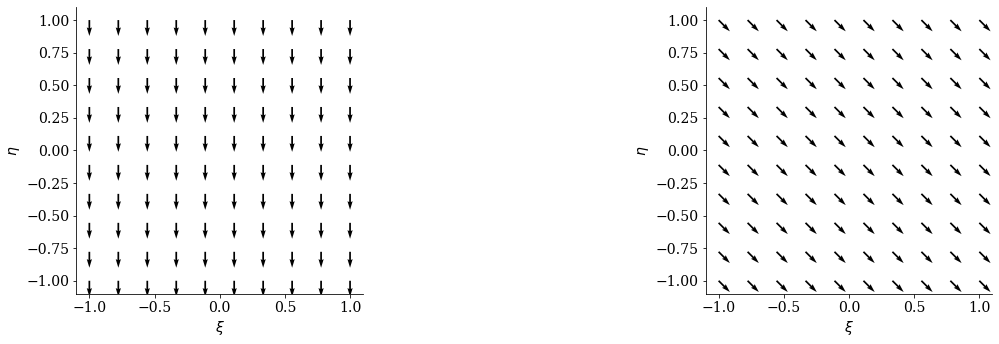

In [22]:
plot_element_gradient([flow_up,flow_right],element_vector[0])

## Potential flow

PDE:

$$
    0 = q_{i,i} \quad \text{with} \quad q_i = - \frac{k_{ij}}{\mu} p_{,j}
$$

so that

$$
    0 = \left(\frac{k_{ij}}{\mu} p_{,j}\right)_{,i}
$$

Weak form:

\begin{align}
    0 &= \int \limits_\Omega v q_{i,i} \,\text{d}\Omega = \int \limits_{\partial \Omega_q} v q_\text{out} \,\text{d}\Gamma - \int \limits_\Omega v_{,i} q_i \,\text{d}\Omega
    \\
    0 &= \int \limits_\Omega v_{,i} \frac{k_{ij}}{\mu} p_{,j} \,\text{d}\Omega - \int \limits_{\partial \Omega_q} v q_\text{in} \,\text{d}\Gamma
\end{align}

Discretized form ($k$ equations):

$$
    0 = \int \limits_\Omega \nabla N_{ik} \frac{k_{ij}}{\mu} \nabla N_{jl} \,\text{d}\Omega\ \hat{p}_l - \int \limits_{\partial \Omega_q} N_k q_\text{in} \,\text{d}\Gamma
$$

and elementwise:

$$
    0 = \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_\Omega \nabla N_{ik} \frac{k_{ij}}{\mu} \nabla N_{jl}\,\det J \,\text{d}\Omega_e\ \hat{p}_l - \bigcup \limits_{e=1}^{n_\text{el}^q} \int \limits_{\partial \Omega_{e,q}} N_k q_\text{in} \det J_\Gamma \,\text{d}\Gamma_e
$$

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side. Local integration is performed by Gauss quadrature:

$$
    \int \limits_{-1}^1 \int \limits_{-1}^1 f(\xi,\eta)\,\text{d}\xi \,\text{d}\eta \approx \sum \limits_{i=1}^{n_\text{gp}} \sum \limits_{j=1}^{n_\text{gp}} f(\xi_i,\eta_j) w_i w_j 
$$

## Local assember

For now without Neumann boundaries.

In [23]:
k = np.diag([1e-14,1e-14])
#k = np.array([[7.6453e-15,4.4140E-15],
#              [4.4140E-15,2.5484E-15]])
mu = 1e-3

In [24]:
def local_assembler(elem):
    K_loc = np.zeros((4,4))
    nip = elem._quad4_element__quad_degree
    for i in range(nip):
        for j in range(nip):
            #local integration point coordinate
            xi = elem._quad4_element__quad_points[i]
            eta = elem._quad4_element__quad_points[j]
            dN_dX = grad_shape_function(xi,eta,elem)
            #determinant of Jacobian
            detJ = np.linalg.det(element_jacobian(xi,eta,elem))
            #integration weight
            w_i = elem._quad4_element__quad_weights[i]
            w_j = elem._quad4_element__quad_weights[j]
            #assembly of local stiffness matrix
            K_loc += np.dot(dN_dX.dot(k/mu),dN_dX.T) * w_i * w_j * detJ
    return K_loc

In [25]:
#local_assembler(element_vector[1])/(1e-11)

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [26]:
def global_assembler(nodes,elements,solution):
    K_glob = np.zeros((len(nodes),len(nodes)))
    b_glob = np.zeros(len(nodes))
    for i,elem in enumerate(elements):
        K_i = local_assembler(elem)
        for n in range(4):
            for n2 in range(4):
                K_glob[elem._quad4_element__global_ids[n],elem._quad4_element__global_ids[n2]] += K_i[n,n2]
    return K_glob, b_glob

## Application of boundary conditions

A Dirichlet boundary condition $\bar{u}$ at node $m$ is introduced into the system $K_{ik} u_k = f_i$ via

$$
    \left(
    \begin{array}{c}
        K_{11} & K_{12} & \dots & K_{1m} & \dots & K_{1n_\text{n}}
        \\
        K_{21} & K_{22} & \dots & K_{2m} & \dots & K_{2n_\text{n}}
        \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
        \\
        K_{m1}:=0 & K_{m2}:=0 & \dots & K_{mm}:=1 & \dots & K_{mn_\text{n}}:=0
        \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
        \\
        K_{n_\text{n}1} & K_{n_\text{n}2} & \dots & K_{n_\text{n}m} & \dots & K_{n_\text{n}n_\text{n}}
    \end{array}    
    \right)
    \left(
    \begin{array}{c}
            u_0\\ u_1\\ \vdots\\ u_m \\ \vdots \\ u_{n_\text{n}}
        \end{array}
    \right)
    =
    \left(
    \begin{array}{c}
            F_0\\ F_1\\ \vdots\\ F_m:=\bar{u} \\ \vdots \\ F_{n_\text{n}}
        \end{array}
    \right)
$$

In [27]:
def apply_Dirichlet_bc(K_glob,b_glob,node_id,value):
    K_glob[node_id,:] = 0.
    K_glob[node_id,node_id] = 1.
    b_glob[node_id] = value
    return K_glob, b_glob

## Problem solution

We now perform the global assembly, apply a vanishing traction on the top and constrain the displacement at the bottom to zero.

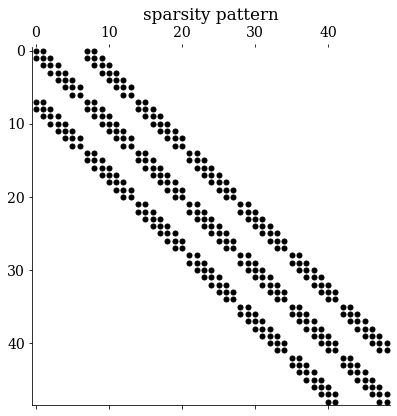

In [28]:
K, f = global_assembler(node_list,element_vector,solution)
plt.spy(K,marker='.')
plt.title('sparsity pattern')
plt.tight_layout()

This clearly shows the sparcity pattern of the resulting matrix. One can on which nodal displacements (pressures) a particular nodal force (flux) depends. One can also recognize the individual elements and their connectivity.

If we plot the entries by magnitude, we observe how element contributions add up on nodes that are shared by many elements. Zero entries are omitted in the plot for better visibility.

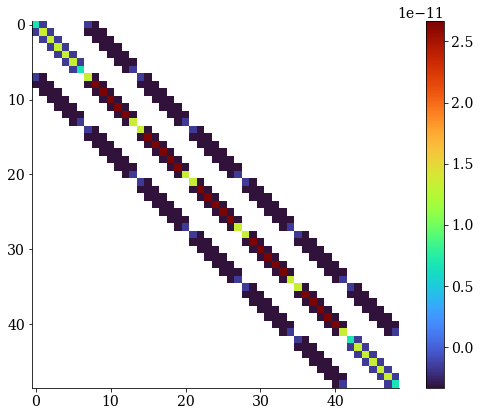

In [29]:
plt.imshow(K, cmap='turbo',alpha=np.where(K==0,0.,1.))
plt.colorbar()
plt.tight_layout();

In [30]:
left = np.where(node_list.T[0]==0)
right = np.where(node_list.T[0]==dx)
for i in left:
    K, f = apply_Dirichlet_bc(K, f, i, 1e6)
for i in right:
    K, f = apply_Dirichlet_bc(K, f, i, 0)

In [31]:
solution = np.linalg.solve(K,f)
K, f = global_assembler(node_list,element_vector,solution)
fluxes = K.dot(solution)

In [32]:
def plot_result(node_list,element_vector):
    fig, ax = plt.subplots(ncols=2,figsize=(18,9))
    ax[0].tricontourf(node_list[:, 0], node_list[:, 1], solution,alpha=0.4)
    ax[0].scatter(node_list[:, 0], node_list[:, 1], c=solution, s=200)
    ax[1].scatter(node_list[:, 0], node_list[:, 1], c=fluxes, s=200)
    for figs in range(2):
        for ne,e in enumerate(element_vector):
            e_coords = e._quad4_element__coords
            for i in range(len(e_coords)):
                ax[figs].plot([e_coords[i-1,0],e_coords[i,0]],[e_coords[i-1,1],e_coords[i,1]],color='blue')
            ax[figs].text(e.get_centroid()[0],e.get_centroid()[1],'%i' %ne, color='blue')
        ax[figs].set_xlabel('$x$')
        ax[figs].set_ylabel('$y$')
        ax[figs].set_aspect('equal')
    for i in range(len(node_list)):
        ax[0].text(node_list[i][0]+dx/150,node_list[i][1]+dy/150,'%.3e' %solution[i])
        ax[1].text(node_list[i][0]+dx/150,node_list[i][1]+dy/150,'%.3e' %fluxes[i])
    fig.suptitle('pressure (left) and nodal flow rates (right)')
    fig.tight_layout()
    #fig.savefig('pressures_and_fluxes.pdf')
    #fig.savefig('pressures_and_fluxes.png')

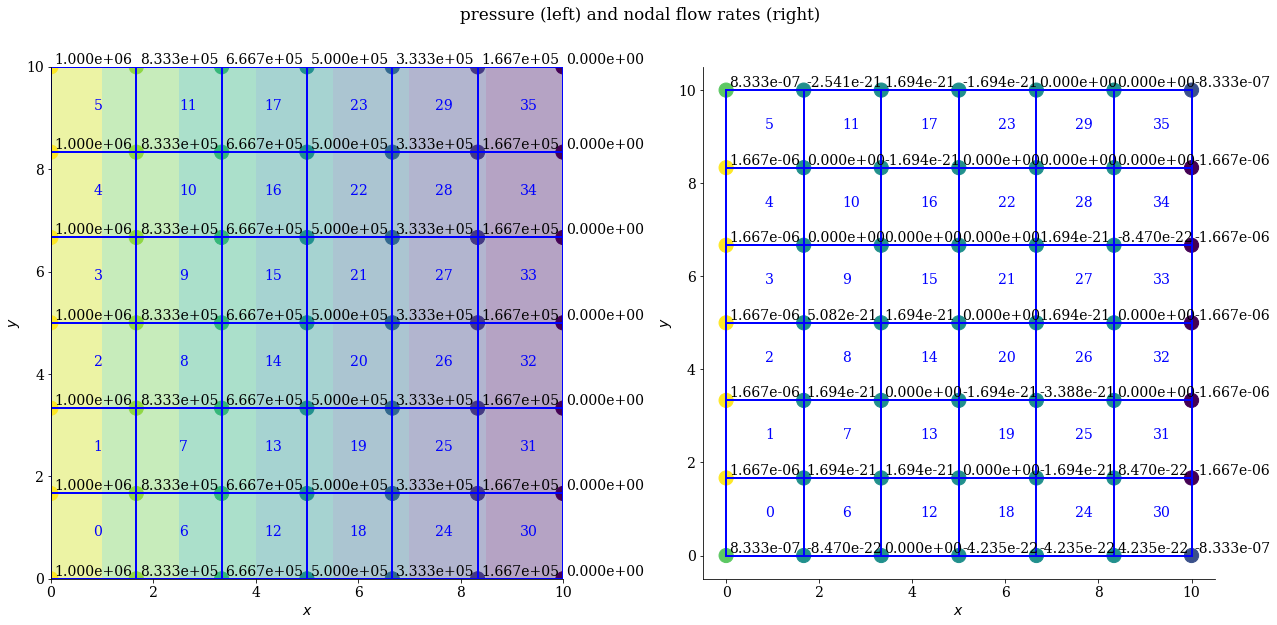

In [33]:
plot_result(node_list,element_vector)

The expected linear profile with the correct boundary conditions is recovered. The nodal flow rates along the Dirichlet boundaries demonstrate in- and outflow through the left and right boundaries, respectively. Observe the signs, and observe how the corner noded have only half the values of interior nodes due to contributions from only one element.

In [34]:
print("Global flow rate imbalance: %.3e" %(np.sum(fluxes)))

Global flow rate imbalance: 1.906e-20


In [35]:
influx = fluxes[np.where(node_list.T[0]==0)].sum()
outflux = fluxes[np.where(node_list.T[0]==dx)].sum()

print("We have %.5e m³/(s m) inflow into and %.5e m³/(s m) outflow out of the domain" %(influx,outflux))

We have 1.00000e-05 m³/(s m) inflow into and -1.00000e-05 m³/(s m) outflow out of the domain


This corresponds to the analytical result:

$$
    Q = \frac{\Delta p}{\Delta x} \frac{k}{\mu} A = \frac{10^6\,\text{Pa}}{10\,\text{m}} \frac{10^{-14}\,\text{m}^2}{10^{-3}\,\text{Pa}\,\text{s}} 10 \frac{\text{m}^2}{\text{m}} = 10^{-5}\,\text{m}^3\,\text{s}^{-1}\,\text{m}^{-1}
$$

## Jacobian demo

Let's assume Darcy's law with a pressure-dependent isotropic permeability in the absence of gravity

$$
    \tilde{\mathbf{w}}_\text{LS} = - \frac{k(p)}{\mu} \nabla p
$$

and in turn focus on the related term in the weak balance often written as a Laplace term:

$$
    \int \limits_\Omega \nabla \mathbf{N}^\text{T} \frac{k(p)}{\mu} \nabla \mathbf{N} \,\text{d}\Omega\ \hat{\mathbf{p}}
$$

where $p = \mathbf{N} \hat{\mathbf{p}}$ and $\nabla p = \nabla \mathbf{N} \hat{\mathbf{p}}$

For simplicity, this matrix-vector product can be written as a vector when included as part of the residual (here exclusive):

$$
    \mathbf{r} = \int \limits_\Omega \nabla \mathbf{N}^\text{T} \frac{k(p)}{\mu} \nabla p \,\text{d}\Omega
$$

or in index notation

$$
    r_i = \int \limits_\Omega \nabla N_{ki} \frac{k(p)}{\mu} p_{,k} \,\text{d}\Omega
$$

The associated linearization into the direction of the nodal pressure increments follows as

\begin{align}
    \frac{\partial r_i}{\partial \hat{p}_m} \Delta \hat{p}_m &= \int \limits_\Omega \nabla N_{ki} \frac{\partial}{\partial p} \left[ \frac{k(p)}{\mu} p_{,k} \right] \frac{\partial p}{\partial \hat{p}_m} \,\text{d}\Omega\ \Delta \hat{p}_m + \int \limits_\Omega \nabla N_{ki} \frac{\partial}{\partial p_{,l}} \left[ \frac{k(p)}{\mu} p_{,k} \right] \frac{\partial p_{,l}}{\partial \hat{p}_m} \,\text{d}\Omega\ \Delta \hat{p}_m
    \\
    &= \int \limits_\Omega \nabla N_{ki} \frac{\partial k(p)}{\partial p} \mu^{-1} p_{,k} N_m \,\text{d}\Omega\ \Delta \hat{p}_m + \int \limits_\Omega \nabla N_{ki} \frac{k(p)}{\mu} \nabla N_{km} \,\text{d}\Omega\ \Delta \hat{p}_m
\end{align}

which recovers the typical result including the Laplace term.

This implementation can be compared to the finite-difference approximation:

\begin{align}
    \frac{\partial r_i(\hat{p}_j)}{\partial \hat{p}_m} \approx \frac{r_i(\hat{p}_j + \epsilon e_m) - r_i(\hat{p}_j - \epsilon e_m)}{2\epsilon}
\end{align}

In [36]:
def perm(p):
    return 1e-10*np.power(p/1e5,2)

def dperm_dp(p):
    return 2.e-5*1e-10*(p/1e5)

nodal_ps = solution[2:6]
nodal_ps

array([1000000., 1000000., 1000000., 1000000.])

In [37]:
def assemble_residual(elem,ps):
    r_loc = np.zeros(4)
    nip = elem._quad4_element__quad_degree
    for i in range(nip):
        for j in range(nip):
            #local integration point coordinate
            xi = elem._quad4_element__quad_points[i]
            eta = elem._quad4_element__quad_points[j]
            N = shape_function(xi,eta)
            dN_dX = grad_shape_function(xi,eta,elem)
            p_ip = N.dot(ps)
            grad_p_ip = dN_dX.T.dot(ps)
            #determinant of Jacobian
            detJ = np.linalg.det(element_jacobian(xi,eta,elem))
            #integration weight
            w_i = elem._quad4_element__quad_weights[i]
            w_j = elem._quad4_element__quad_weights[j]
            #assembly of local stiffness matrix
            r_loc += dN_dX.dot(perm(p_ip)/mu*grad_p_ip) * w_i * w_j * detJ
    return r_loc

In [38]:
def assemble_Jac(elem,ps):
    K_loc = np.zeros((4,4))
    nip = elem._quad4_element__quad_degree
    for i in range(nip):
        for j in range(nip):
            #local integration point coordinate
            xi = elem._quad4_element__quad_points[i]
            eta = elem._quad4_element__quad_points[j]
            N = shape_function(xi,eta)
            dN_dX = grad_shape_function(xi,eta,elem)
            p_ip = N.dot(ps)
            grad_p_ip = dN_dX.T.dot(ps)
            #determinant of Jacobian
            detJ = np.linalg.det(element_jacobian(xi,eta,elem))
            #integration weight
            w_i = elem._quad4_element__quad_weights[i]
            w_j = elem._quad4_element__quad_weights[j]
            #assembly of local stiffness matrix
            K_loc += np.dot(dN_dX.dot(perm(p_ip)/mu),dN_dX.T) * w_i * w_j * detJ
            K_loc += np.outer(dN_dX.dot(dperm_dp(p_ip)/mu*grad_p_ip),N) * w_i * w_j * detJ
    return K_loc

In [39]:
print("Analytical inner Jacobian\n\n", assemble_Jac(element_vector[1],nodal_ps))

Analytical inner Jacobian

 [[ 6.66666667e-06 -1.66666667e-06 -3.33333333e-06 -1.66666667e-06]
 [-1.66666667e-06  6.66666667e-06 -1.66666667e-06 -3.33333333e-06]
 [-3.33333333e-06 -1.66666667e-06  6.66666667e-06 -1.66666667e-06]
 [-1.66666667e-06 -3.33333333e-06 -1.66666667e-06  6.66666667e-06]]


In [40]:
epsilon = lambda p: np.maximum(1e-8,1e-8*p)

In [41]:
# could use forward differences to safe one set of evaluations
def CentralDiff(elem):
    Jac = np.zeros((4,4))
    for j in range(len(nodal_ps)):
        upper_p = np.copy(nodal_ps)
        lower_p = np.copy(nodal_ps)
        eps = epsilon(nodal_ps[j])
        upper_p[j] += eps
        lower_p[j] -= eps
        Jac[:,j] = (assemble_residual(elem,upper_p) - assemble_residual(elem,lower_p))/(2.*eps)
    return Jac

In [42]:
# could use forward differences to safe one set of evaluations
def ForwardDiff(elem):
    Jac = np.zeros((4,4))
    r0 = assemble_residual(elem,nodal_ps)
    for j in range(len(nodal_ps)):
        upper_p = np.copy(nodal_ps)
        eps = epsilon(nodal_ps[j])
        upper_p[j] += eps
        Jac[:,j] = (assemble_residual(elem,upper_p) - r0)/eps
    return Jac

In [43]:
print("Numerical outer Jacobian (central differences)\n\n", CentralDiff(element_vector[1]))
print("\n\nNumerical outer Jacobian (forward differences)\n\n", ForwardDiff(element_vector[1]))

Numerical outer Jacobian (central differences)

 [[ 6.66666669e-06 -1.66666664e-06 -3.33333335e-06 -1.66666667e-06]
 [-1.66666664e-06  6.66666669e-06 -1.66666667e-06 -3.33333335e-06]
 [-3.33333337e-06 -1.66666667e-06  6.66666668e-06 -1.66666666e-06]
 [-1.66666667e-06 -3.33333337e-06 -1.66666666e-06  6.66666668e-06]]


Numerical outer Jacobian (forward differences)

 [[ 6.66666674e-06 -1.66666666e-06 -3.33333335e-06 -1.66666668e-06]
 [-1.66666666e-06  6.66666674e-06 -1.66666668e-06 -3.33333335e-06]
 [-3.33333339e-06 -1.66666669e-06  6.66666673e-06 -1.66666670e-06]
 [-1.66666669e-06 -3.33333339e-06 -1.66666670e-06  6.66666673e-06]]


In [44]:
print("Relative difference between both (central differences), rounded to 1e-8 \n\n", np.round((assemble_Jac(element_vector[1],nodal_ps) - CentralDiff(element_vector[1]))/assemble_Jac(element_vector[1],nodal_ps),8))
print("\n\nRelative difference between both (forward differences), rounded to 1e-8 \n\n", np.round((assemble_Jac(element_vector[1],nodal_ps) - ForwardDiff(element_vector[1]))/assemble_Jac(element_vector[1],nodal_ps),8))

Relative difference between both (central differences), rounded to 1e-8 

 [[-0.e+00  1.e-08 -1.e-08 -0.e+00]
 [ 1.e-08 -0.e+00 -0.e+00 -1.e-08]
 [-1.e-08 -0.e+00 -0.e+00  0.e+00]
 [-0.e+00 -1.e-08  0.e+00 -0.e+00]]


Relative difference between both (forward differences), rounded to 1e-8 

 [[-1.e-08  0.e+00 -0.e+00 -1.e-08]
 [ 0.e+00 -1.e-08 -1.e-08 -1.e-08]
 [-2.e-08 -1.e-08 -1.e-08 -2.e-08]
 [-1.e-08 -2.e-08 -2.e-08 -1.e-08]]


Equivalence ....